In [3]:
!pip install git+https://github.com/adolliou/euispice_coreg
import numpy as np


  Cloning https://github.com/adolliou/euispice_coreg to c:\users\adolliou\appdata\local\temp\pip-req-build-_jpneo66
  Resolved https://github.com/adolliou/euispice_coreg to commit a0162e1499eed67b27740a6178d54b36d8a4c622
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'


  Running command git clone --filter=blob:none --quiet https://github.com/adolliou/euispice_coreg 'C:\Users\adolliou\AppData\Local\Temp\pip-req-build-_jpneo66'

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


# eui_spice_coreg

This code provides tools to correct the pointing information imagers images and SPICE raster. The algorithm cross-correlates images with others, and correct the headers values. The co-alignment can be performed within the following frames:

   - Helioprojective. In this case both images will be reprojected into the coordinate frame of the image to align.
   - Carrington: Slower, you have to provide the information to build a pixel grid in a carrington frame. Required if there is a significant time delay between both instruments, or if they do not share the same spacecraft (HRIEUV and AIA for instance).
   - Pixels. The algorithm slicing over the image pixels, complitely neglecting the headers information. (experimental)

## Installation

This package is designed to be used in your personal python projects, and to be imported as a standard package. In your project, a virtual environement can be created with the following command in the shell :

```terminal
python -m venv env
source env/bin/activate
```
You can use the pip install + git command, while you are in virtual environment, to install the package into your own project.
```terminal
pip install git+https://github.com/adolliou/euispice_coreg
```
You can also clone the euispice_coreg repository locally. Then, while you are in the virtual environment of your personal project, you can add the Alignment package with the following command :
```terminal
cd path/to/euispice_coreg
pip install .
```



## Example of EUI co-alignment with FSI 174
### Helioprojective frame


We define the lag values, which will be added to the original header values of the FITS file to align.
- lag_crval1 : "CRVAL1"
- lag_crval2 : "CRVAL2"
- lag_crota : "CROTA" 
- lag_cdelt1 : "CDELT1"
- lag_cdelt2 : "CDELT2"


In [4]:
from euispice_coreg.hdrshift.alignment import Alignment
from euispice_coreg.plot.plot import PlotFunctions
from euispice_coreg.utils.Util import AlignCommonUtil
path_fsi = ("https://www.sidc.be/EUI/data/releases/202204_release_5.0/L2/2022/03/17/solo_L2_eui-fsi174"
                "-image_20220317T095045281_V01.fits")
path_hri = ("https://www.sidc.be/EUI/data/releases/202204_release_5.0/L2/2022/03/17/solo_L2_eui-hrieuv174"
                "-image_20220317T095045277_V01.fits")

path_hri_output = "l2_hri_corrected.fits"
lag_crval2 = np.arange(5, 11, 1)
lag_crval1 = np.arange(15, 26, 1)

lag_cdelta1 = [0]
lag_cdelta2 = [0]

lag_crota = [0.75]
params_lag = {
    "lag_crval1": lag_crval1,
    "lag_crval2": lag_crval2,
    "lag_crota": lag_crota,
    "lag_cdelta1": lag_cdelta1,
    "lag_cdelta2": lag_cdelta2,
}



We create an instance of the Alignment class, with the reference fits (large_fov) and the FITS to align (small_fov) paths and windows. The correlation matrix is computed with the align_using_helioprojective method, using cross-correlations. The alingment is done on the Helioprojective frame of the FITS to align.

In [5]:
A = Alignment(large_fov_known_pointing=path_fsi, small_fov_to_correct=path_hri, large_fov_window=-1,
               small_fov_window=-1,
              parallelism=True, use_tqdm=True, counts_cpu_max=20,  **params_lag)

corr_helio = A.align_using_helioprojective(method='correlation')

Plot of the correlation matrix, and the images before and after alignment, with contours.

C:\Users\adolliou\PycharmProjects\euispice_coreg_notebook\.venv\Lib\site-packages\euispice_coreg\plot\plot.py:156: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


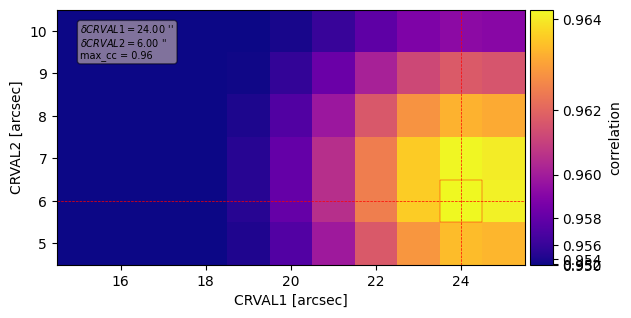

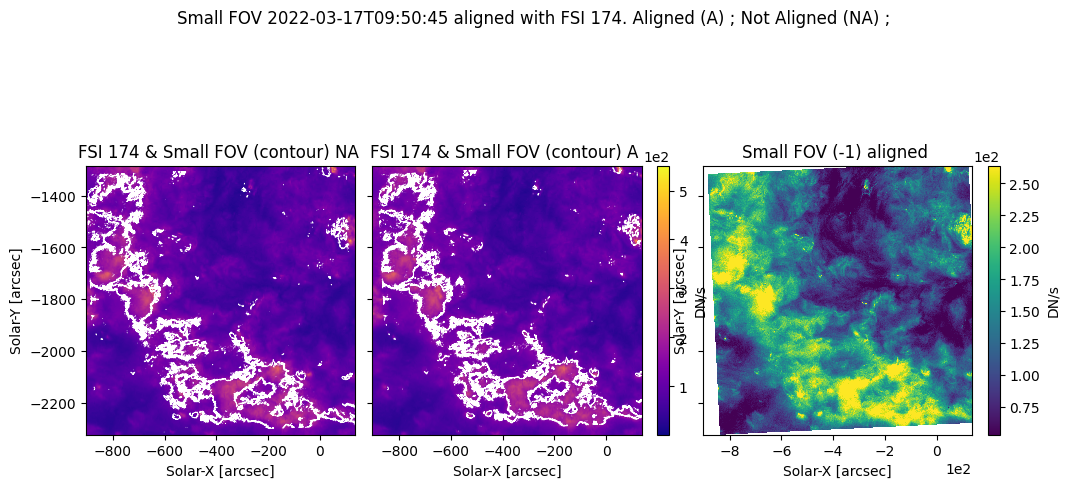

In [6]:
PlotFunctions.plot_correlation(corr=corr_helio, lag_crval1=lag_crval1, lag_crval2=lag_crval2, show=True)
PlotFunctions.plot_co_alignment(corr=corr_helio,large_fov_path=path_fsi, large_fov_window=-1, small_fov_path=path_hri, small_fov_window=-1, **params_lag)

Save the co-aligned FITS file on the path_l3_output path.

In [7]:
AlignCommonUtil.write_corrected_fits(corr=corr_helio, path_l2_input=path_hri, window_list=[-1], path_l3_output=path_hri_output, 
                                     **params_lag)


## Carrington coordinates

C:\Users\adolliou\PycharmProjects\euispice_coreg_notebook\.venv\Lib\site-packages\euispice_coreg\plot\plot.py:156: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


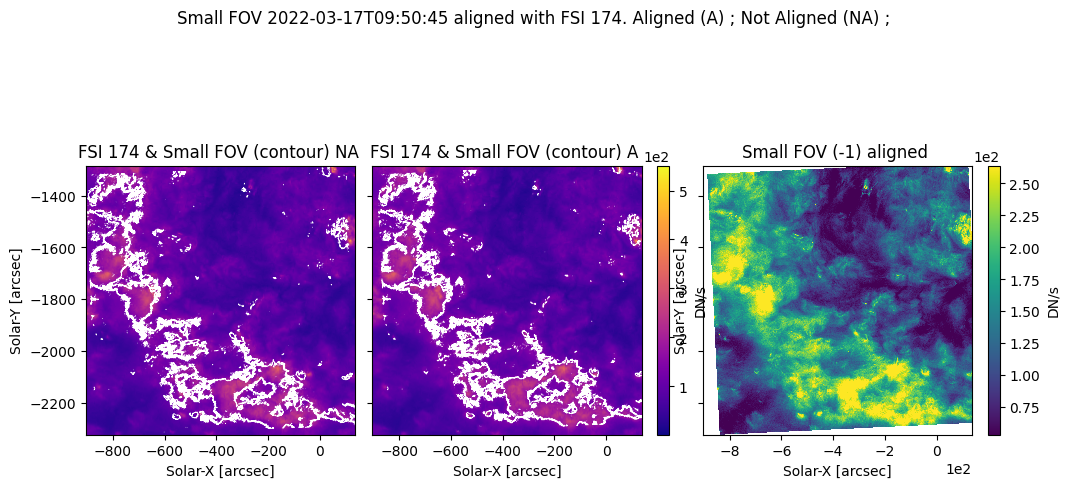

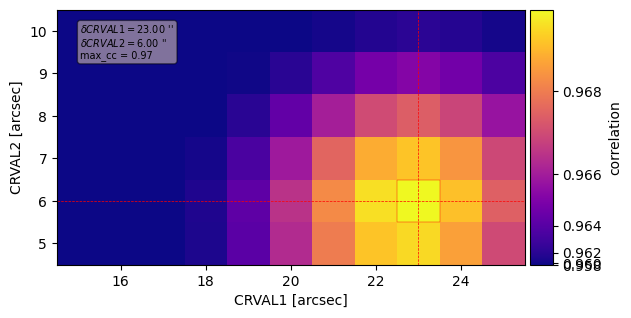

In [8]:
reference_date = "2022-03-17T09:50:45"
lonlims = (230, 260)
latlims = (-65, -35)  # longitude min and max (degrees)
parallelism = True
shape = (2400, 2400)

corr_carr = A.align_using_carrington(method='correlation', shape=shape, lonlims=lonlims, latlims=latlims,reference_date=reference_date)


PlotFunctions.plot_co_alignment(corr=corr_carr,large_fov_path=path_fsi, large_fov_window=-1, small_fov_path=path_hri, small_fov_window=-1, **params_lag)
PlotFunctions.plot_correlation(corr=corr_carr, lag_crval1=lag_crval1, lag_crval2=lag_crval2, show=True)

AlignCommonUtil.write_corrected_fits(corr=corr_helio, path_l2_input=path_hri, window_list=[-1], path_l3_output=path_hri_output, 
                                     **params_lag)


## Co-alignment of a SPICE raster with a FSI 304 raster
### Creation of a synthetic raster


First of all, we need to create a synthetic raster for the SPICE raster using a list of FSI 304 FITS files. For each raster step, the FSI files closest in time are selected. Then, the FSI file is reprojected into the pixel position of the raster step. This is repeated for each step. 

In [9]:
from euispice_coreg.synras.map_builder import SPICEComposedMapBuilder
import astropy.units as u
import os
path_folder = "https://www.sidc.be/EUI/data/releases/202301_release_6.0/L2/2022/03/17/"
path_fsi_list = [
    os.path.join(path_folder, "solo_L2_eui-fsi304-image_20220317T000300228_V02.fits"), 
     os.path.join(path_folder, "solo_L2_eui-fsi304-image_20220317T000400208_V02.fits"), 
     os.path.join(path_folder, "solo_L2_eui-fsi304-image_20220317T000500208_V02.fits"), 
     os.path.join(path_folder, "solo_L2_eui-fsi304-image_20220317T000600208_V02.fits"), 
     os.path.join(path_folder, "solo_L2_eui-fsi304-image_20220317T000700208_V02.fits"), 
     os.path.join(path_folder, "solo_L2_eui-fsi304-image_20220317T000800208_V02.fits"), 
     os.path.join(path_folder, "solo_L2_eui-fsi304-image_20220317T000900208_V02.fits"), 
     os.path.join(path_folder, "solo_L2_eui-fsi304-image_20220317T001000208_V02.fits"),
     os.path.join(path_folder, "solo_L2_eui-fsi304-image_20220317T001000208_V02.fits"),
     os.path.join(path_folder, "solo_L2_eui-fsi304-image_20220317T001100208_V02.fits"), 
     os.path.join(path_folder, "solo_L2_eui-fsi304-image_20220317T001200208_V02.fits"), 
     os.path.join(path_folder, "solo_L2_eui-fsi304-image_20220317T001300208_V02.fits"), 
     os.path.join(path_folder, "solo_L2_eui-fsi304-image_20220317T001400209_V02.fits"), 
     os.path.join(path_folder, "solo_L2_eui-fsi304-image_20220317T001500209_V02.fits"), 
     os.path.join(path_folder, "solo_L2_eui-fsi304-image_20220317T001600209_V02.fits"), 
]



path_spice = ("https://spice.osups.universite-paris-saclay.fr/spice-data/release-3.0/level2/2022/03/17"
                  "/solo_L2_spice-n-ras_20220317T000032_V02_100663831-000.fits")
window_spice = "Ly-gamma-CIII group (Merged)" # The window of the HDULIST for the SPICE FITS file. 
window_imager = -1 # The widow of the HDULIST of the imagers FITS files
threshold_time = u.Quantity(300, "s") # maximum threshold between the SPICE acquisition time, and the closest FSI 304 image. If the code can't any FSI below the threshold, it returns an error 
output_L3_fits = ""

C = SPICEComposedMapBuilder(path_to_spectro=path_spice, list_imager_paths=path_fsi_list,
                               window_imager=window_imager, window_spectro=window_spice,
                               threshold_time=threshold_time)
C.process(folder_path_output=output_L3_fits)


Use imager solo_L2_eui-fsi304-image_20220317T001600209_V02.fits

Use imager solo_L2_eui-fsi304-image_20220317T001600209_V02.fits

Use imager solo_L2_eui-fsi304-image_20220317T001600209_V02.fits

Use imager solo_L2_eui-fsi304-image_20220317T001600209_V02.fits

Use imager solo_L2_eui-fsi304-image_20220317T001600209_V02.fits

Use imager solo_L2_eui-fsi304-image_20220317T001600209_V02.fits

Use imager solo_L2_eui-fsi304-image_20220317T001600209_V02.fits

Use imager solo_L2_eui-fsi304-image_20220317T001600209_V02.fits

Use imager solo_L2_eui-fsi304-image_20220317T001500209_V02.fits

Use imager solo_L2_eui-fsi304-image_20220317T001500209_V02.fits

Use imager solo_L2_eui-fsi304-image_20220317T001500209_V02.fits

Use imager solo_L2_eui-fsi304-image_20220317T001500209_V02.fits

Use imager solo_L2_eui-fsi304-image_20220317T001500209_V02.fits

Use imager solo_L2_eui-fsi304-image_20220317T001500209_V02.fits

Use imager solo_L2_eui-fsi304-image_20220317T001400209_V02.fits

Use imager solo_L2_eui-f

C:\Users\adolliou\PycharmProjects\euispice_coreg_notebook\.venv\Lib\site-packages\euispice_coreg\synras\map_builder.py:114: UserWarning: CRPIX3 no in original header. It is not added to the synthetic raster header
  warnings.warn(f"{k} no in original header. It is not added to the synthetic raster header")
C:\Users\adolliou\PycharmProjects\euispice_coreg_notebook\.venv\Lib\site-packages\euispice_coreg\synras\map_builder.py:114: UserWarning: CRPIX4 no in original header. It is not added to the synthetic raster header
  warnings.warn(f"{k} no in original header. It is not added to the synthetic raster header")
C:\Users\adolliou\PycharmProjects\euispice_coreg_notebook\.venv\Lib\site-packages\euispice_coreg\synras\map_builder.py:114: UserWarning: CRVAL3 no in original header. It is not added to the synthetic raster header
  warnings.warn(f"{k} no in original header. It is not added to the synthetic raster header")
C:\Users\adolliou\PycharmProjects\euispice_coreg_notebook\.venv\Lib\site-pac

## Co alignment of the SPICE C III image with the synthetic raster


C:\Users\adolliou\PycharmProjects\euispice_coreg_notebook\.venv\Lib\site-packages\euispice_coreg\hdrshift\alignment.py:385: UserWarning: Units of headers in deg: Modyfying inputs units to deg.
  warnings.warn("Units of headers in deg: Modyfying inputs units to deg.")
C:\Users\adolliou\PycharmProjects\euispice_coreg_notebook\.venv\Lib\site-packages\euispice_coreg\plot\plot.py:156: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


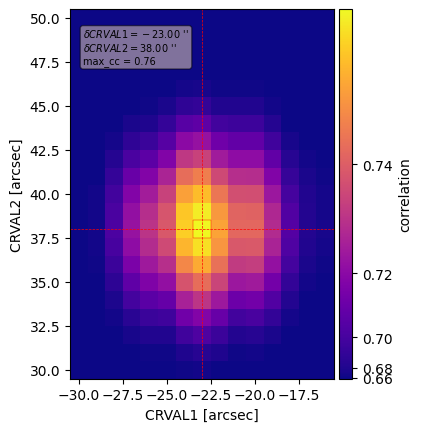

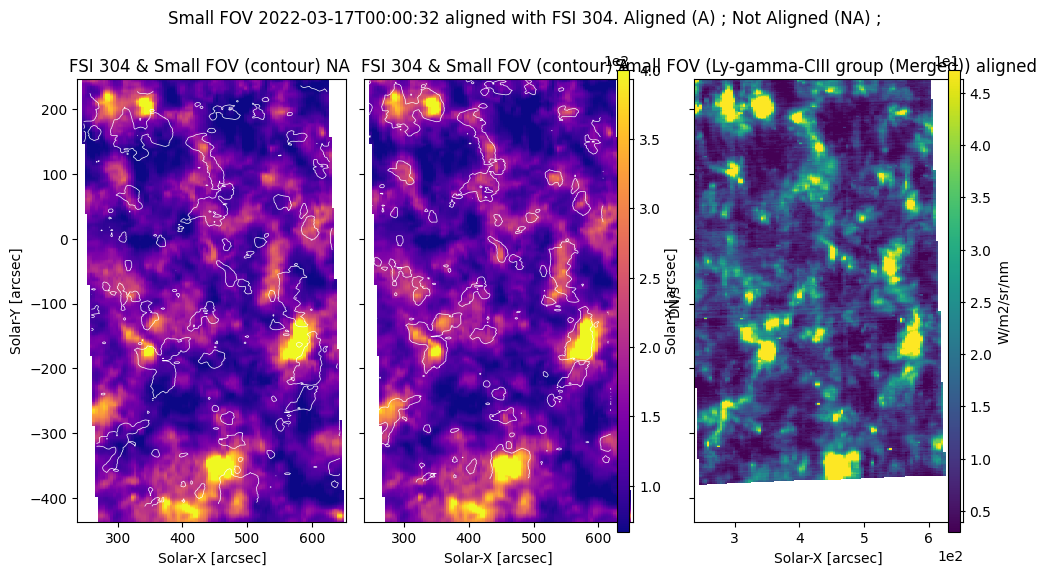

In [10]:
from euispice_coreg.hdrshift.alignment_spice import AlignmentSpice
from euispice_coreg.plot.plot import PlotFunctions
from euispice_coreg.utils.Util import AlignCommonUtil

lag_crval1 = np.arange(-30, -15, 1)
lag_crval2 = np.arange(30, 51, 1)
lag_crota = np.array([0])
lag_cdelta1 = np.array([0])
lag_cdelta2 = np.array([0])
window_spice = "Ly-gamma-CIII group (Merged)" # The window of the HDULIST for the SPICE FITS file. 
path_fsi = "solo_L3_FSI304-image-composed-2022-03-17T00_08_54.fits"
parallelism = True
params_lag = {
    "lag_crval1": lag_crval1,
    "lag_crval2": lag_crval2,
    "lag_crota": lag_crota,
    "lag_cdelta1": lag_cdelta1,
    "lag_cdelta2": lag_cdelta2,
}

path_spice_output = "aligned_spice.fits"

A = AlignmentSpice(large_fov_known_pointing=path_fsi, small_fov_to_correct=path_spice,
parallelism=parallelism,large_fov_window=-1, small_fov_window=window_spice,
                   **params_lag)

corr_helio = A.align_using_helioprojective(method='correlation')
PlotFunctions.plot_correlation(corr=corr_helio, lag_crval1=lag_crval1, lag_crval2=lag_crval2, show=True)

PlotFunctions.plot_co_alignment(corr=corr_helio,large_fov_path=path_fsi, large_fov_window=-1, small_fov_path=path_spice, small_fov_window=window_spice, **params_lag)
AlignCommonUtil.write_corrected_fits(corr=corr_helio, path_l2_input=path_spice, window_list=[0, 1, 2, 3, 4, 5], path_l3_output=path_spice_output, 
                                     **params_lag)

## Alignment with pixels (works, but not thoroughly tested)

C:\Users\adolliou\PycharmProjects\euispice_coreg_notebook\.venv\Lib\site-packages\euispice_coreg\pxlshift\alignment_pixels.py:93: Warning: CROTA must be in degree
  warnings.warn("CROTA must be in degree", Warning)


corrected solar rotation on FSI on CRVAL1: dx=-0.006160096656321395, dy=0.000291620075655363


dx = -225: 100%|██████████| 5/5 [00:01<00:00,  4.94it/s]


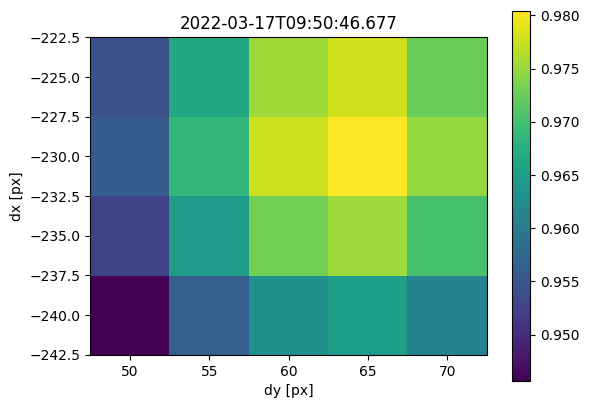

-230
65


C:\Users\adolliou\PycharmProjects\euispice_coreg_notebook\.venv\Lib\site-packages\euispice_coreg\plot\plot.py:199: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
C:\Users\adolliou\PycharmProjects\euispice_coreg_notebook\.venv\Lib\site-packages\euispice_coreg\plot\plot.py:176: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


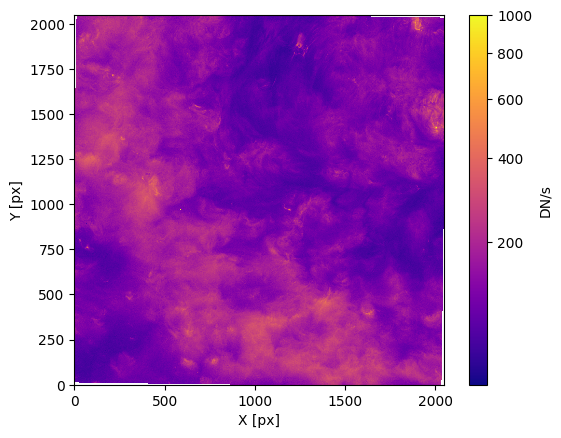

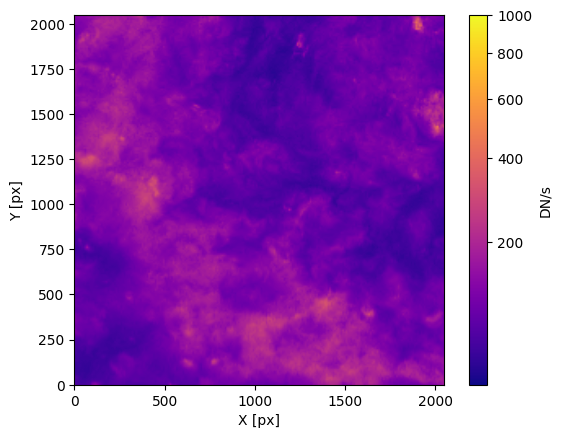

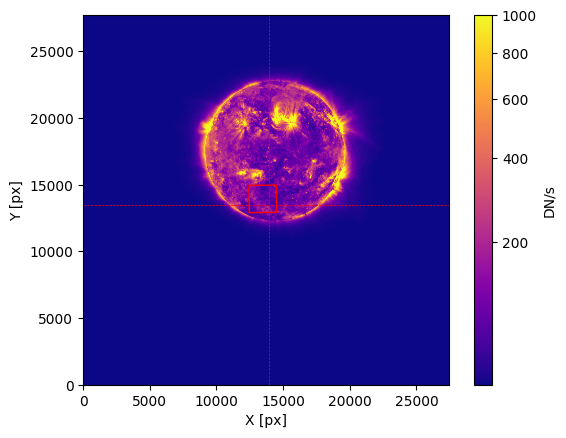

In [11]:
from euispice_coreg.pxlshift.alignment_pixels import AlignmentPixels
from euispice_coreg.plot.plot import PlotFunctions
from euispice_coreg.utils.Util import AlignCommonUtil
from matplotlib import pyplot as plt
from astropy.visualization import ImageNormalize, LogStretch
from astropy.io import fits

lag_dx = np.arange(-240, -220, 5)
lag_dy = np.arange(50, 75, 5)
lag_drot = np.array([0.75])
unit = "degree"

path_hri = "https://www.sidc.be/EUI/data/releases/202204_release_5.0/L2/2022/03/17/solo_L2_eui-hrieuv174-image_20220317T095045277_V01.fits "
path_fsi= ("https://www.sidc.be/EUI/data/releases/202204_release_5.0/L2/2022/03/17/solo_L2_eui-fsi174-image_20220317T095045281_V01.fits ")


A = AlignmentPixels(large_fov_known_pointing=path_fsi, small_fov_to_correct=path_hri, window_large=-1,
                    window_small=-1)
corr = A.find_best_parameters(lag_dx=lag_dx, lag_dy=lag_dy, lag_drot=lag_drot, unit_rot=unit,
                              shift_solar_rotation_dx_large=True)

# PlotFunctions.plot_correlation(corr=corr, lag_crval1=lag_dx, lag_crval2=lag_dy, show=True, lag_dx_label='dx [px]', lag_dy_label='dy [px]')

# 
norm = ImageNormalize(stretch=LogStretch(5), vmin=1, vmax=1000)
max_index = np.unravel_index(corr.argmax(), corr.shape)
with fits.open(path_hri) as hdul_small:
    hdu_small = hdul_small[-1]
    hdr_small = hdu_small.header.copy()
    data_small = np.array(hdu_small.data.copy(), dtype=np.float64)
    for ii, theta in enumerate(lag_drot):
        plt.figure()
        dx = lag_dx[1] - lag_dx[0]
        dy = lag_dy[1] - lag_dy[0]
        plt.imshow(corr[:, :, ii], origin='lower', interpolation=None,
                   extent=(lag_dy[0] - 0.5*dx, lag_dy[-1] + 0.5*dx, lag_dx[0] - 0.5*dy, lag_dx[-1] + 0.5*dy))
        plt.xlabel('dy [px]')
        plt.ylabel('dx [px]')
        plt.title(hdr_small["DATE-AVG"])
        plt.colorbar()
        plt.show()
    hdul_small.close()

slc = (slice(A.slc_small_ref[0].start + lag_dy[max_index[1]], A.slc_small_ref[0].stop + lag_dy[max_index[1]]),
   slice(A.slc_small_ref[1].start + lag_dx[max_index[0]], A.slc_small_ref[1].stop + lag_dx[max_index[0]]))
print(lag_dx[max_index[0]])
print(lag_dy[max_index[1]])

# PlotFunctions.plot_fov(A.data_small, norm=norm)
PlotFunctions.plot_fov(A.data_small_rotated, norm=norm)
PlotFunctions.plot_fov(A.data_large, slc=slc, norm=norm)
# PlotFunctions.plot_fov(A.data_large, norm=norm)
delta_pix1 = lag_dx[max_index[0]]
delta_pix2 = lag_dy[max_index[1]]
PlotFunctions.plot_fov_rectangle(A.data_large, slc=slc, norm=norm, angle=lag_drot[max_index[2]])
hdr_shifted = AlignCommonUtil.align_pixels_shift(delta_pix1=delta_pix1, delta_pix2=delta_pix2,
                                               windows=[-1], large_fov_fits_path=path_fsi,
                                               small_fov_path=path_hri, large_fov_window=-1)
crval1 = hdr_shifted["CRVAL1"]
crval2 = hdr_shifted["CRVAL2"]